In [1]:
import pandas as pd
import numpy as np
import math

## Importing and Preprocessing Data

In [2]:


def haversine(lat1, lon1, lat2, lon2):
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371.0

    # Calculate the result
    return c * r

x = pd.read_csv('random_sets.csv').iloc[:125,:]
split = x['Numbers'].str.split(",")
x = np.zeros((125, 20))
for i in range(125):
    idx = np.array(split[i], dtype=int)-1
    x[i,idx] = 1
y = pd.read_csv('total_travel_time.csv')['total_travel_time'].to_numpy()
data_with_cluster_labels = pd.read_csv('data_with_cluster_labels.csv')
data_with_cluster_labels_nonull = data_with_cluster_labels[data_with_cluster_labels['cluster_label'].notna()]
data_with_cluster_labels_nonull_20 = data_with_cluster_labels_nonull[(data_with_cluster_labels_nonull['cluster_label'] <= 20) & (data_with_cluster_labels_nonull['cluster_label'] >= 1)]
# Calculate the mean of x and y for each cluster
data_with_cluster_labels_nonull_20_grouped = data_with_cluster_labels_nonull_20.groupby('cluster_label').agg({'x': 'mean', 'y': 'mean'}).reset_index()

# Rename columns
data_with_cluster_labels_nonull_20_grouped.columns = ['cluster_label', 'mean_x', 'mean_y']
vertiport_loc_dic = {}
for i in range(20):
    vertiport_loc_dic[i+1] = (data_with_cluster_labels_nonull_20_grouped['mean_x'][i], data_with_cluster_labels_nonull_20_grouped['mean_y'][i])
vertiport_network = np.zeros((125, 20, 20))
for i in range(125):
    for j in range(20):
        for k in range(20):
            if x[i, j] == 1 and x[i, k] == 1:
                vertiport_network[i, j, k] = haversine(vertiport_loc_dic[j+1][1], vertiport_loc_dic[j+1][0], vertiport_loc_dic[k+1][1], vertiport_loc_dic[k+1][0])
vertiport_network = vertiport_network.reshape(125, 400)


In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


## RandomForest Regression

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
grid = {'n_estimators': [i for i in range(1,20)],
        'min_samples_split': [i for i in range(2,10)],
        'max_features' : [i for i in range(8, 20, 2)]}
cv_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))

# print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  1154220.5951740837
RMSE:  1303475.4628331673
MAPE:  0.050962148415998734


In [6]:
fitted.best_estimator_

RandomForestRegressor(max_features=8, min_samples_split=9, n_estimators=10)

In [7]:
sampled_yhat = fitted.best_estimator_.predict(x_train)
print('MAE: ', mean_absolute_error(y_train, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_train, sampled_yhat)))

MAE:  767715.9952581691 RMSE:  906217.2508570285


## XGBoost

In [8]:
from xgboost import XGBRegressor
grid = {'n_estimators': [i for i in range(1,20)]}
cv_rf = GridSearchCV(estimator = XGBRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [9]:
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))
print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  2624167.76
RMSE:  2922967.6999258134
MAPE:  0.11584673534571426
MAE:  2624167.76 RMSE:  2922967.6999258134


In [10]:
sampled_yhat = fitted.best_estimator_.predict(x_train)
print('MAE: ', mean_absolute_error(y_train, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_train, sampled_yhat)))

MAE:  2797879.63 RMSE:  3045582.6903246953


## NN

In [11]:
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_nn = x_scaler.fit_transform(x_train)
y_train_nn = y_scaler.fit_transform(y_train.reshape(-1,1))


input_shape = (x_train.shape[0], x_train.shape[1])


model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(258, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1))
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer='adam')
model.fit(x_train_nn, y_train_nn[:,np.newaxis],epochs=500, batch_size=32)


2023-07-21 00:31:14.227808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
4/4 [==============================] - 1s 6ms/step - loss: 1.0384
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 0.8762
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 0.7287
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 0.6662
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 0.5176
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3970
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3342
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2819
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2549
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2110
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1931
Epoch 12/500
4/4 [==============================] - 0s 13ms/step - loss: 0.2007
Epoch 13/500
4/4 [==============================] - 0s 5ms/s

In [12]:
x_test_nn = x_scaler.transform(x_test)
y_test_nn = y_scaler.transform(y_test.reshape(-1,1))

predicted = model.predict(x_test_nn)
predicted = y_scaler.inverse_transform(predicted)

1/1 [==============================] - 0s 143ms/step


In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predicted)))
print('MAPE: ', mean_absolute_percentage_error(y_test, predicted))

print('MAE: ', mean_absolute_error(y_test, predicted), 'RMSE: ', np.sqrt(mean_squared_error(y_test, predicted)))

MAE:  1286135.36
RMSE:  1497391.8667002837
MAPE:  0.052851594360158544
MAE:  1286135.36 RMSE:  1497391.8667002837


## GA Optimziation

In [14]:
class GA:
    def __init__(self, population, model):
        self.population = population
        self.model = model


    def eval(self):
        self.y_predicted = self.model.best_estimator_.predict(self.population)
        sorted_idx = np.argsort(self.y_predicted)
        self.population = self.population[sorted_idx]

    def crossover(self, num_cross_overs):
        for i in range(0, 2*num_cross_overs, 2):
            cutoff = np.random.randint(5,15)
            recombined_i = np.concatenate([self.population[i, :cutoff], self.population[i+1, cutoff:]])
            recombined_i_1 = np.concatenate([self.population[i+1, :cutoff], self.population[i, cutoff:]])

            self.population[i] = recombined_i
            self.population[i+1] = recombined_i_1
    
    def mutation(self, num_mutations, num_each=1):
        for i in range(num_mutations):
            sample = self.population[i]
            mute_genes = np.random.randint(0, 20, num_each)
            sample[mute_genes] = abs(sample[mute_genes] - 1)
            self.population[i] = sample



In [15]:
pop = GA(x, fitted)
for i in range(1000):
    pop.eval()
    pop.crossover(50)
    pop.mutation(50)
pop.eval()

In [16]:
pop.population[0]

array([0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0.])

In [17]:
pop.y_predicted[0]

2261951500.0

In [18]:
y < pop.y_predicted[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [19]:
np.any(np.array([np.array_equal(row, pop.population[0]) for row in x]))
## False means it's not one of the solutions found in the original problem


False

In [20]:
test_set = pd.read_csv('test_set2.csv')

In [21]:
test_set['num_steps'].sum() < y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

[Text(0.5, 1.0, 'Savings with the Optimal Set'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Travel Time Difference (M)'),
 (-20000000.0, 0.0)]

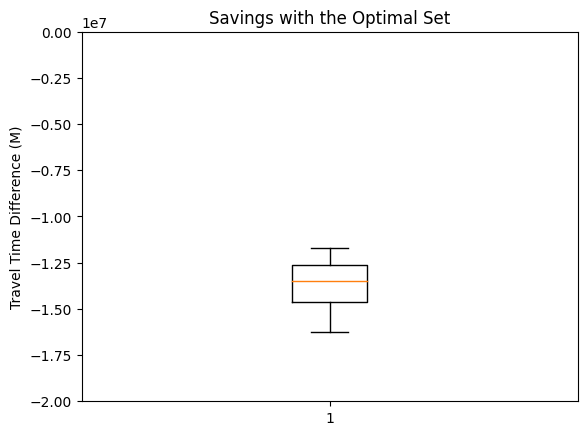

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.boxplot(test_set['num_steps'].sum() - y)
ax.set(title='Savings with the Optimal Set',
       xlabel='',
       ylabel='Travel Time Difference (M)',
       ylim=(-2*10**7, 0))

In [23]:
pop.population[0][:20]

array([0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0.])